# Projet Maths-Info

On cherche à tracer les lignes de niveau d'une fonction à deux variables.

In [3]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect

Pour une fonction f continue, si c ∈ [f(0,0),f(0,1)] ou c ∈ [f(0,1),f(0,0)], alors le théorème des valeurs intermédiaires garantit l'existence d'un t ∈ [0,1] tel que f(0,t) = c
On choisit donc cette condition.

Pour le programme find_seed, nous procédons par dichotomie.

In [2]:
def dichotomie(f,a,b,epsilon):
    g,d=a,b
    while (d-g)>epsilon:
        c=(d+g)/2
        if f(a)*f(c)<0:
            d=c
        else:
            g=c
    return c


def find_seed(g, c=0.0, eps=2**(-26)):
    if (g(0,0)-c)*(g(0,1)-c)<0:
        tmp=lambda x : g(0,x)-c  
        return dichotomie(tmp,0,1,2**-26)
    else:
        return None

Le gradient étant toujours orthogonal aux lignes de niveaux, nous calculons le gradient pour prendre un vecteur orthogonal. On lui donne une norme delta et on l'additionne à notre point x,y précédent.

In [4]:
def grad_f(x, y):
    g = autograd.grad
    return np.r_[g(f, 0)(x, y), g(f, 1)(x, y)]


def simple_contour(f, c=0.0, delta=0.01):
    X,Y=[],[]
    d0=find_seed(f,c)
    if d0!=None:
        x,y=0.0001,d0
        gradient=grad_f(x,y)
        s = 1
        if gradient[1] < 0:
            s = -1
        print(s)
        while 0<=x<1 and 0<=y<1:
            X.append(x)
            Y.append(y)
            gradient=grad_f(x,y)
            n=[gradient[1],-gradient[0]]
            norme=s*np.sqrt(n[0]**2+n[1]**2)
            if norme!=0:
                x+=delta/norme*n[0]
                y+=delta/norme*n[1]
            else:
                break
        
    return X,Y

On teste la fonction sur un exemple.

1


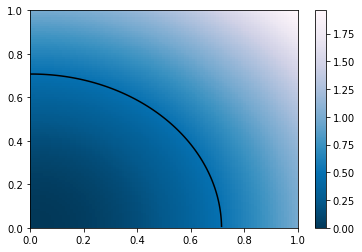

In [11]:
f=lambda x,y:x**2+y**2
X,Y=np.linspace(0,1,100),np.linspace(0,1,100)

X,Y=np.meshgrid(X,Y)

Z=f(X,Y)

plt.pcolormesh(X, Y, Z,cmap='PuBu_r')
plt.colorbar()

X_l,Y_l=simple_contour(f,0.5)
plt.plot(X_l,Y_l,color="black")

Pour la fonction contour, nous avons du adapter la fonction find_seed pour pouvoir trouver un point sur n'importe quel coté d'une case de la grille crée. Nous avons écrit une fonction case qui trouve tous les points de la ligne de niveau dans une case. 

In [10]:
def find_seed_4(g,c,x0,y0,x1,y1, eps=2**(-26)):
    if (g(x0,y0)-c)*(g(x0,y1)-c)<0:
        tmp=lambda x : g(x0,x)-c  
        return x0,dichotomie(tmp,y0,y1,2**-26)
    if (g(x0,y1)-c)*(g(x1,y1)-c)<0:
        tmp=lambda x : g(x,y1)-c  
        return dichotomie(tmp,x0,x1,2**-26),y1
    if (g(x1,y1)-c)*(g(x1,y0)-c)<0:
        tmp=lambda x : g(x1,x)-c  
        return x1,dichotomie(tmp,y0,y1,2**-26)
    if (g(x1,y0)-c)*(g(x0,y0)-c)<0:
        tmp=lambda x : g(x,y0)-c  
        return dichotomie(tmp,x0,x1,2**-26),y0
    else:
        return None,None

def case(f,c,x0,y0,x1,y1,delta):
    X,Y=[],[]
    x,y=find_seed_4(f,c,x0,y0,x1,y1)
    if x!=None:
        gradient=grad_f(x+0.00001,y+0.00001)
        n=[gradient[1],-gradient[0]]
        norme=np.sqrt(n[0]**2+n[1]**2)
        if norme!=0:
            x+=delta/norme*n[0]
            y+=delta/norme*n[1]            
        s = -1
        if x0<=x<=x1 and y0<=y<=y1:
            s = 1
        while x0<=x<=x1 and y0<=y<=y1:
            X.append(x)
            Y.append(y)
            gradient=grad_f(x+0.00001,y+0.00001)
            n=[gradient[1],-gradient[0]]
            norme=s*np.sqrt(n[0]**2+n[1]**2)
            if norme!=0:
                x+=delta/norme*n[0]
                y+=delta/norme*n[1]
            else:
                break
    return X,Y


def contour(f, c=0.0, xc=[0.0,1.0], yc=[0.0,1.0], delta=0.01):
    X, Y = [], []
    n = len(xc) - 1
    for i in range(n):
        for j in range(n):
            a,b = case(f,c,xc[i],yc[j],xc[i+1],yc[j+1],delta)
            X += a
            Y += b

    return X,Y

Nous essayons la fonction sur un exemple

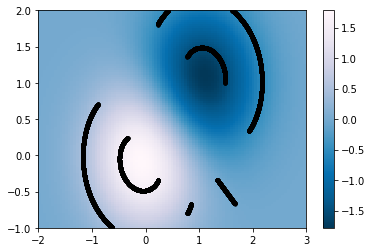

In [15]:
f=lambda x,y:2*(np.exp(-x**2-y**2)-np.exp(-(x-1)**2-(y-1)**2))
X,Y=np.linspace(-2,3,100),np.linspace(-1,2,100)

X,Y=np.meshgrid(X,Y)

Z=f(X,Y)

plt.pcolormesh(X, Y, Z,cmap='PuBu_r')
plt.colorbar()
case_x=10
case_y=10
X_l,Y_l=contour(f,0.0,list(np.linspace(-2,3,case_x)),list(np.linspace(-1,2,case_y)),0.001)
plt.plot(X_l,Y_l,".",color="black")

X_l,Y_l=contour(f,0.5,list(np.linspace(-2,3,case_x)),list(np.linspace(-1,2,case_y)),0.001)
plt.plot(X_l,Y_l,".",color="black")

X_l,Y_l=contour(f,-0.5,list(np.linspace(-2,3,case_x)),list(np.linspace(-1,2,case_y)),0.001)
plt.plot(X_l,Y_l,".",color="black")

X_l,Y_l=contour(f,1.5,list(np.linspace(-2,3,case_x)),list(np.linspace(-1,2,case_y)),0.001)
plt.plot(X_l,Y_l,".",color="black")

X_l,Y_l=contour(f,-1.5,list(np.linspace(-2,3,case_x)),list(np.linspace(-1,2,case_y)),0.001)
plt.plot(X_l,Y_l,".",color="black")

plt.show()